In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt   #We use matplotlib library for plotting
import matplotlib.image as mpimg  
import matplotlib.colors as clr
import numpy as np 
import cv2 as cv

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

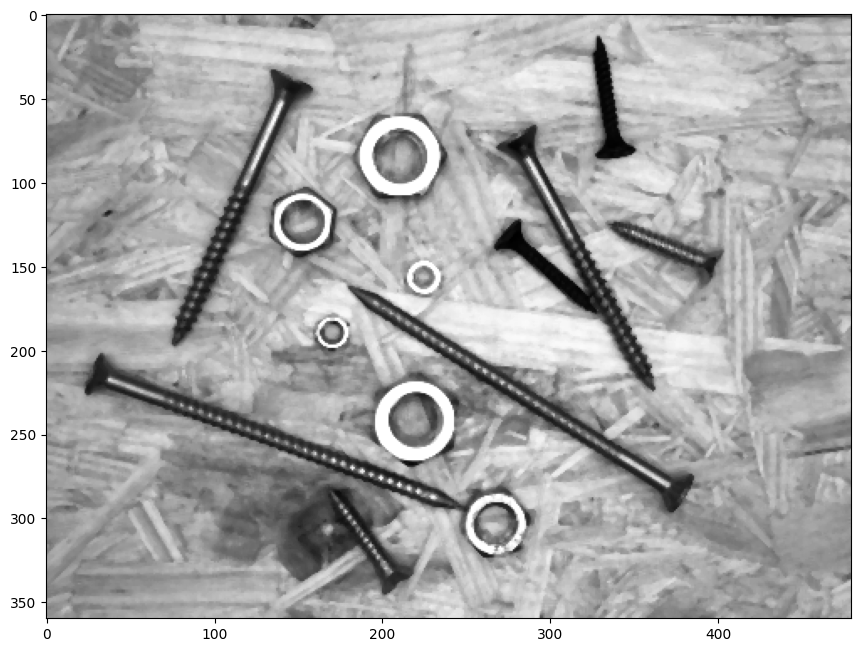

In [122]:
img = cv.imread("test_data/screws_375.png")
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_rgb= cv.resize(img_rgb, (480, 360))
gray = cv.cvtColor(img_rgb, cv.COLOR_RGB2GRAY)
gray = cv.medianBlur(gray,3)
plt.imshow(gray, cmap = 'gray')

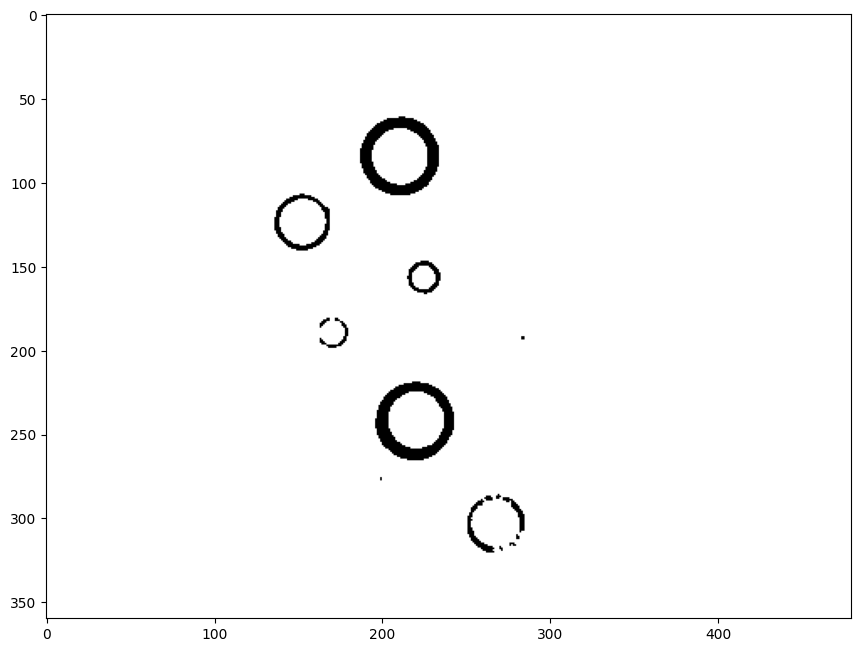

In [123]:
ret, thresh = cv.threshold(gray,250,255,cv.THRESH_BINARY_INV)
kernel = np.ones((1,1),np.uint8)
#thresh = cv.medianBlur(thresh,3)
plt.imshow(thresh, cmap = 'gray')

Text(0.5, 1.0, 'Unknown area')

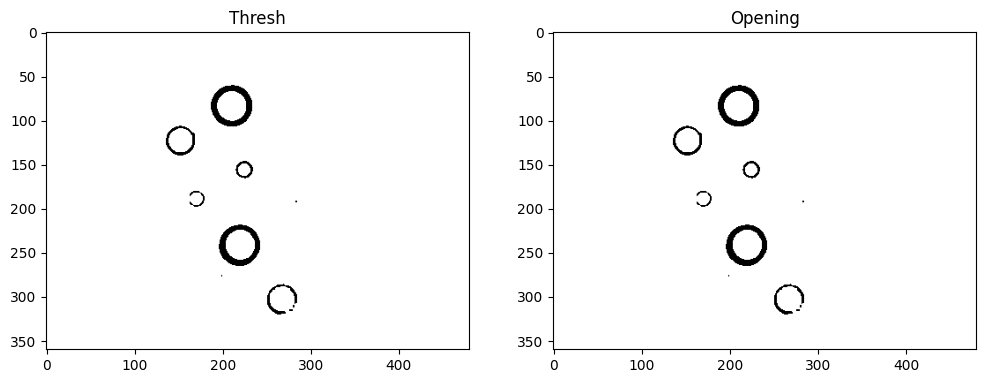

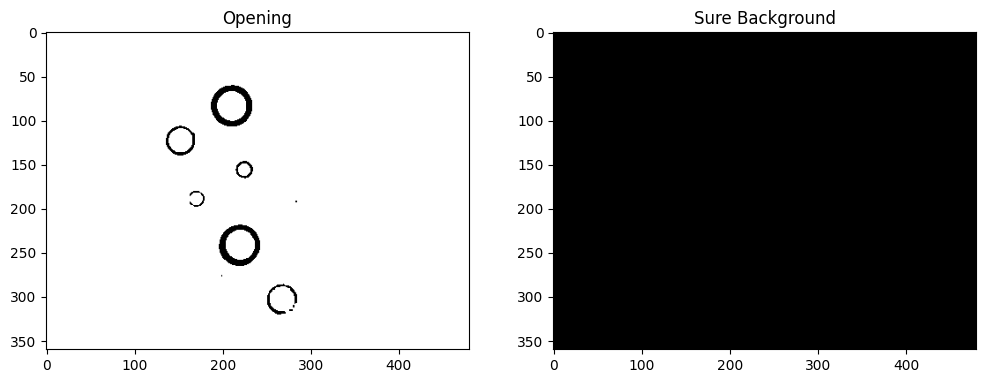

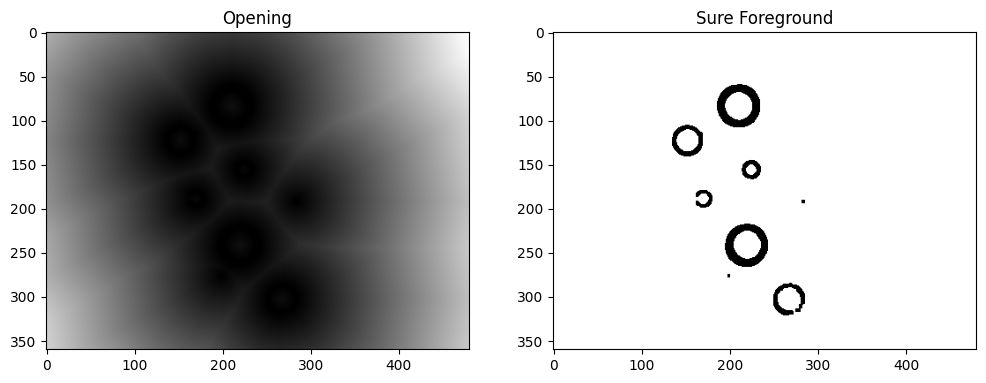

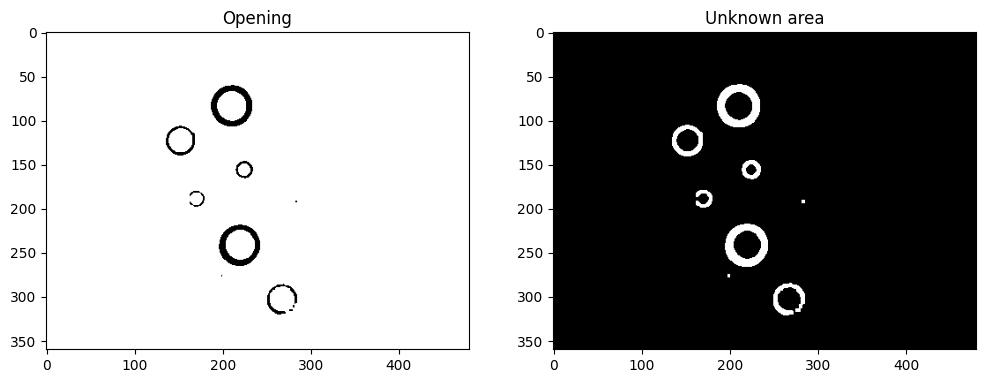

In [124]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)
kernel = np.ones((1,1),np.uint8)
closing = cv.morphologyEx(opening,cv.MORPH_DILATE,kernel, iterations = 1)

fig, axs = plt.subplots(1,2)
axs[0].imshow(opening, cmap = 'gray') #, clim = (220,250))
axs[0].set_title('Thresh')
axs[1].imshow(closing, cmap = 'gray')
axs[1].set_title('Opening')

# sure background area
kernel = np.ones((3,3),np.uint8)
sure_bg = cv.dilate(opening,kernel,iterations=4)

fig, axs = plt.subplots(1,2)
axs[0].imshow(opening, cmap = 'gray') #, clim = (220,250))
axs[0].set_title('Opening')
axs[1].imshow(sure_bg, cmap = 'gray')
axs[1].set_title('Sure Background')

# Finding sure foreground area
dist_transform = cv.distanceTransform(closing,cv.DIST_L2,5)
ret, sure_fg = cv.threshold(dist_transform,0.007*dist_transform.max(),255,0)

fig, axs = plt.subplots(1,2)
axs[0].imshow(dist_transform, cmap = 'gray') #, clim = (220,250))
axs[0].set_title('Opening')
axs[1].imshow(sure_fg, cmap = 'gray')
axs[1].set_title('Sure Foreground')

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)

fig, axs = plt.subplots(1,2)
axs[0].imshow(opening, cmap = 'gray') #, clim = (220,250))
axs[0].set_title('Opening')
axs[1].imshow(unknown, cmap = 'gray')
axs[1].set_title('Unknown area')

4


Text(0.5, 1.0, 'Blur + Morph + Threshold')

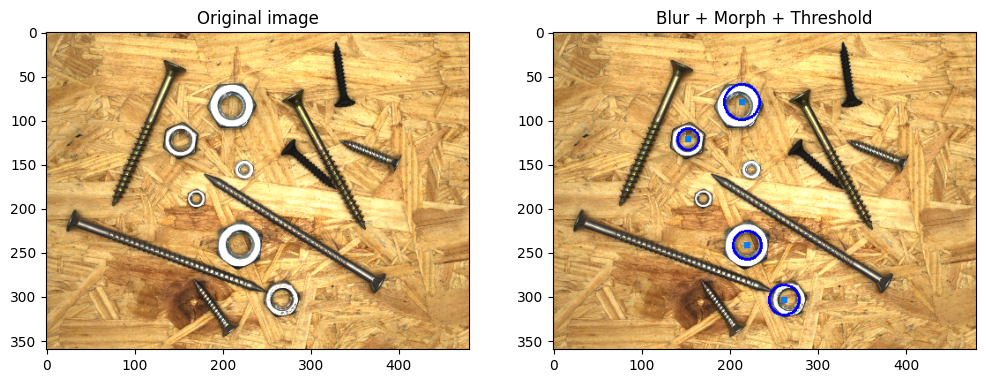

In [125]:
copy = img_rgb.copy()
size = (np.max(unknown))/16
circles = cv.HoughCircles(unknown, cv.HOUGH_GRADIENT, 1.4, size, param1=300, param2=31, minRadius=0,maxRadius=70)
num = len(circles[0])
print(len(circles[0]))
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")

    for (x, y, r) in circles:
        cv.circle(copy, (x, y), r, (0, 0, 255), 2)
        cv.rectangle(copy, (x - 3, y - 3), (x + 3, y + 3), (0, 128, 255), -1)
        
fig, axs = plt.subplots(1,2)
axs[0].imshow(img_rgb) #, clim = (220,250))
axs[0].set_title('Original image')
axs[1].imshow(copy)
axs[1].set_title('Blur + Morph + Threshold')

8


Text(0.5, 1.0, 'Blur + Morph + Threshold')

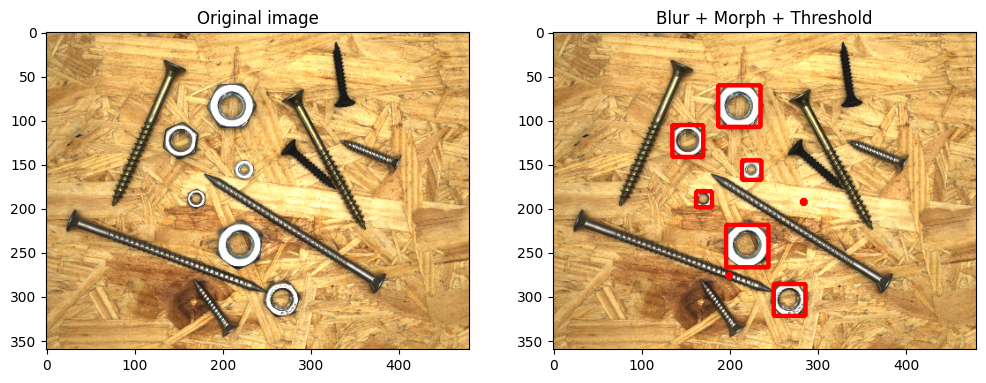

In [126]:
fidelity = False
fidelityValue = 1.7

copy1 = img_rgb.copy()
c, h = cv.findContours(unknown, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
fidelityRange = 0
if fidelity:
    maxArea = .0
    for i in c: # With images it is convenient to know the greater area
        area = cv.contourArea(i)
        if area > maxArea:
            maxArea = area
    fidelityRange = maxArea - (maxArea * fidelityValue) # If objects have same size it prevents false detection

totalContours = 0

br = []
for i in range(len(c)):
    if h[0][i][3] == -1 and cv.contourArea(c[i]) >= fidelityRange:
        totalContours += 1
        approx = cv.approxPolyDP(c[i], 3, True)
        br.append(cv.boundingRect(approx))
for b in br:
    cv.rectangle(copy1, (b[0], b[1]), (b[0] + b[2], b[1] + b[3]), (255, 0, 0), 3)
    
print(totalContours)
    
fig, axs = plt.subplots(1,2)
axs[0].imshow(img_rgb) #, clim = (220,250))
axs[0].set_title('Original image')
axs[1].imshow(copy1)
axs[1].set_title('Blur + Morph + Threshold')